# Explorer notebook

### Imports

In [1]:
import os
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
import pymysql


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

## CONSTANTS

### Connection to DB

In [3]:
# Connexion database
db_user = os.getenv('IMPRESSO_MYSQL_USER')
db_host = os.getenv('IMPRESSO_MYSQL_HOST')
db_name = os.getenv('IMPRESSO_MYSQL_DB')
db_password = os.getenv('IMPRESSO_MYSQL_PWD')
db_url = f'mysql://{db_user}:{db_password}@{db_host}/{db_name}?charset=utf8'
engine = create_engine(db_url, poolclass=NullPool)

In [4]:
# Debug in case environment variables cannot be found
#print(os.environ)
#print(db_user)

### Load Useful Data

In [5]:
newspapers_df = pd.read_sql('SELECT * FROM impresso.newspapers;', engine)
issues_df = pd.read_sql('SELECT * FROM impresso.issues;', engine)

In [6]:
newspapers_languages_df = pd.read_sql('SELECT * FROM newspapers_languages;', engine)
languages_df = pd.read_sql('SELECT * FROM languages;', engine)
LANGUAGES = languages_df.code.unique()

In [7]:
newspapers_metadata_df = pd.read_sql('SELECT * FROM newspapers_metadata;', engine)
meta_properties_df = pd.read_sql('SELECT * FROM meta_properties;', engine)
PROPERTIES = meta_properties_df.name.unique()

### Example from Christian

In [8]:
data = pd.read_sql('SELECT impresso.issues.id, impresso.issues.year, \
impresso.issues.month, impresso.issues.day, impresso.issues.newspaper_id, \
impresso.newspapers.title FROM impresso.issues, impresso.newspapers WHERE \
impresso.newspapers.id = impresso.issues.newspaper_id ORDER BY impresso.issues.year ASC, \
impresso.issues.month ASC, impresso.issues.day ASC', engine)


In [9]:
data.head()

,id,year,month,day,newspaper_id,title
0,EXP-1740-01-01-a,1740,1,1,EXP,L'Express
1,EXP-1740-01-29-a,1740,1,29,EXP,L'Express
2,EXP-1740-04-04-a,1740,4,4,EXP,L'Express
3,EXP-1740-07-14-a,1740,7,14,EXP,L'Express
4,NZZ-1780-01-12-a,1780,1,12,NZZ,Neue Zürcher Zeitung


In [10]:
data['datetime'] = pd.to_datetime(data.year*10000+data.month*100+data.day,format='%Y%m%d')


In [11]:
data.head()

,id,year,month,day,newspaper_id,title,datetime
0,EXP-1740-01-01-a,1740,1,1,EXP,L'Express,1740-01-01
1,EXP-1740-01-29-a,1740,1,29,EXP,L'Express,1740-01-29
2,EXP-1740-04-04-a,1740,4,4,EXP,L'Express,1740-04-04
3,EXP-1740-07-14-a,1740,7,14,EXP,L'Express,1740-07-14
4,NZZ-1780-01-12-a,1780,1,12,NZZ,Neue Zürcher Zeitung,1780-01-12


### Explorer

##### Export to CSV to work in case of connection issue

In [12]:
#newspapers_df.to_csv(r'../local-data/newspapers.csv')

In [13]:
#recover1 = pd.read_csv('../local-data/newspapers.csv', index_col=0)
#recover1.head()

In [14]:
#issues_df.to_csv(r'../local-data/issues.csv')

In [15]:
#recover2 = pd.read_csv('../local-data/issues.csv', index_col=0)
#recover2.head()

### Filter newpapers based on properties

In [30]:
def np_by_language(language):

    assert language in LANGUAGES, "Can't recognize selected languages. Please chose one among existing languages in db."
    
    # Find ID
    lang_id = languages_df.loc[languages_df['code']==language]['id'].item()
    return newspapers_languages_df.loc[newspapers_languages_df['language_id']==lang_id]['newspaper_id']

In [17]:
def np_by_property(property_name, filter_):

    assert property_name in PROPERTIES, "Can't recognize selected property. \
    Please chose one among existing ones in db meta_properties."
    
    # Find ID
    prop_id = meta_properties_df.loc[meta_properties_df['name']==property_name]['id'].item()
    
    # TODO : check if filter is one of values for given property ?

    return newspapers_metadata_df.loc[(newspapers_metadata_df['property_id']==prop_id)\
                                     & (newspapers_metadata_df['value']==filter_)]['newspaper_id']

### Number of newspaper issues by year/decade

In [18]:
# Create new decade column
issues_df['decade'] = issues_df.apply(lambda row: row.year-row.year%10, axis = 1) 

In [72]:
time_granularity = 'decade' # put 'year' to have statistics per year
columns_group = ['newspaper_id', time_granularity]
# NP we are interested in : default is all use functions np_by_language / np_by_property to filter np
#newspapers_select = newspapers_df['id'].unique() #default : all
#newspapers_select = ['actionfem', 'armeteufel'] # for rapid visualization
newspapers_select = np_by_property('provinceCode', 'VS')

In [73]:
PROPERTIES

array(['archivalHolder', 'countryCode', 'currentPeriodicity',
       'deliveredIssueNb', 'deliveredPageNb', 'editor', 'expectedIssueNb',
       'expectedPageNb', 'formerPeriodicity', 'founder',
       'ingestedIssueNb', 'ingestedPageNb', 'isbn', 'longTitle',
       'noteGenealogy', 'notePublicationDates', 'otherTitle',
       'periodicity', 'polOrientation', 'pressType', 'provinceCode',
       'publicationDates', 'publicationPlace', 'publisher', 'relatedUrl',
       'variantTitle', 'provenanceId', 'provenanceSource',
       'provenanceUri', 'logoFilename', 'availabilityEta'], dtype=object)

In [74]:
issues_df_select = issues_df.loc[issues_df['newspaper_id'].isin(newspapers_select)]

In [75]:
issue_per_np_time = issues_df_select.groupby(columns_group).count()

In [76]:
nb_issue_per_np_time_id = issue_per_np_time['id']

In [77]:
# Check if all columns have the same number of lines
for col in issues_df.columns :
    if not col in columns_group and not nb_issue_per_np_time_id.equals(issue_per_np_time[col]) :
        print("Problem with column {} : not the same count number.".format(col))

Problem with column last_modified : not the same count number.


Column last_modified is often NaT, which is why the count is not the same. For that others we always have the same number so we can take any column (and we take 'id').

In [78]:
# convert to df in order to plot
nb_issue_per_np_time_id = issue_per_np_time['id']
nb_issue_per_np_time_id = nb_issue_per_np_time_id.reset_index(name='count')
nb_issue_per_np_time_id.head(5)

,newspaper_id,decade,count
0,CDV,1840,304
1,CDV,1850,896
2,LCE,1860,621
3,LCE,1870,883
4,LCE,1880,677


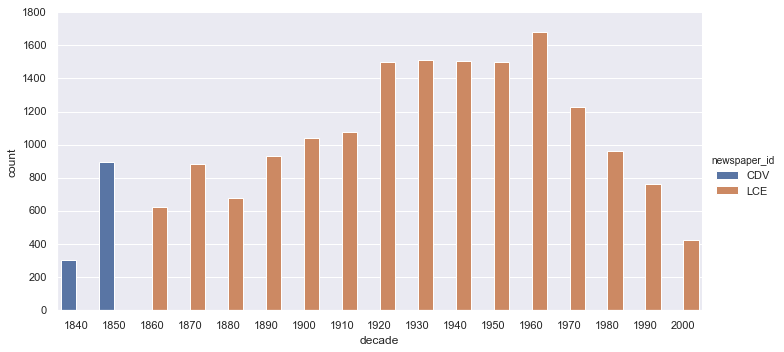

In [79]:
# Plot
sns.catplot(x=time_granularity, y="count", hue="newspaper_id", kind="bar", \
            data=nb_issue_per_np_time_id, height=5, aspect=2);

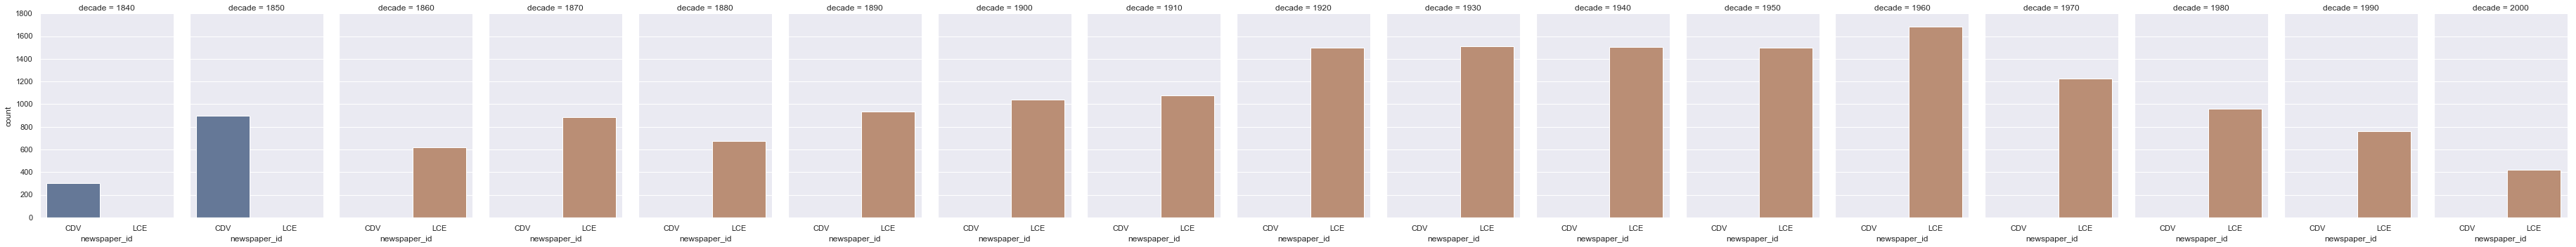

In [80]:
g = sns.catplot(x="newspaper_id", y="count", col=time_granularity, data=nb_issue_per_np_time_id,
                saturation=.5, kind="bar", ci=None, aspect=.6);